# Import 및 데이터 불러오기

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx

from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [6]:
# 데이터 로딩 및 전처리
df = pd.read_csv('../Dataset/최종합데이터.csv')  # 적절한 파일명으로 변경
print(df.head())


   TRAVEL_ID  VISIT_AREA_NM  RESIDENCE_TIME_MIN  DGSTFN  REVISIT_INTENTION  \
0  a_a015688         프로방스마을                60.0     4.0                4.0   
1  a_a015688          다온무인텔               360.0     3.0                2.0   
2  a_a015688        헤이리예술마을               150.0     4.0                4.0   
3  a_a015688     아이노스 출판단지점                30.0     5.0                4.0   
4  a_a015688  롯데프리미엄아울렛 파주점                90.0     5.0                5.0   

   RCMDTN_INTENTION            COMBINED_ADDR GENDER  AGE_GRP  FAMILY_MEMB  \
0               4.0       경기 파주시 탄현면 새오리로 77      남       30            3   
1               3.0      경기 파주시 탄현면 성동로 7-25      남       30            3   
2               3.0  경기 파주시 탄현면 법흥리 1652-239      남       30            3   
3               5.0           경기 파주시 문발로 142      남       30            3   
4               5.0           경기 파주시 문발로 284      남       30            3   

   TRAVEL_COMPANIONS_NUM  
0                      0  
1             

# 그래프 만들기

In [14]:

import torch
from torch_geometric.data import Data

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# 데이터 로드
data = df

# 범주형 데이터 인코딩
gender_encoder = LabelEncoder()
data['GENDER'] = gender_encoder.fit_transform(data['GENDER'])

visit_area_encoder = LabelEncoder()
data['VISIT_AREA_NM'] = visit_area_encoder.fit_transform(data['VISIT_AREA_NM'])

# 노드 인덱스 생성
travel_id_encoder = LabelEncoder()
data['travel_id_idx'] = travel_id_encoder.fit_transform(data['TRAVEL_ID'])

visit_area_nm_encoder = LabelEncoder()
data['visit_area_nm_idx'] = visit_area_nm_encoder.fit_transform(data['VISIT_AREA_NM']) + data['travel_id_idx'].nunique()

# 특성 스케일링
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[['RESIDENCE_TIME_MIN', 'DGSTFN', 'REVISIT_INTENTION', 'RCMDTN_INTENTION']])
data[['RESIDENCE_TIME_MIN', 'DGSTFN', 'REVISIT_INTENTION', 'RCMDTN_INTENTION']] = scaled_features

# PyG 그래프 데이터 생성
pyg_graphs = []
for travel_id in data['TRAVEL_ID'].unique():
    sub_data = data[data['TRAVEL_ID'] == travel_id]
    
    # 노드 특성
    x_travel_id = sub_data[['GENDER', 'AGE_GRP', 'FAMILY_MEMB', 'TRAVEL_COMPANIONS_NUM']].iloc[0].to_numpy()
    x_visit_area_nm = sub_data[['RESIDENCE_TIME_MIN', 'DGSTFN', 'REVISIT_INTENTION', 'RCMDTN_INTENTION']].to_numpy()
    
    x = torch.tensor(np.vstack((x_travel_id, x_visit_area_nm)), dtype=torch.float)
    
    # 엣지 인덱스
    edge_index = torch.tensor([sub_data['travel_id_idx'].to_numpy(), sub_data['visit_area_nm_idx'].to_numpy()], dtype=torch.long)
    
    # 엣지 가중치 계산 (여기서는 간단하게 평균을 사용합니다. 필요에 따라 다른 방법을 선택할 수 있습니다.)
    edge_attr = torch.tensor(np.mean(x_visit_area_nm, axis=1), dtype=torch.float).unsqueeze(1)
    
    # 그래프 데이터 객체 생성
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    pyg_graphs.append(graph_data)

# 첫 번째 그래프 데이터 출력
print(pyg_graphs[0])

Data(x=[8, 4], edge_index=[2, 7], edge_attr=[7, 1])


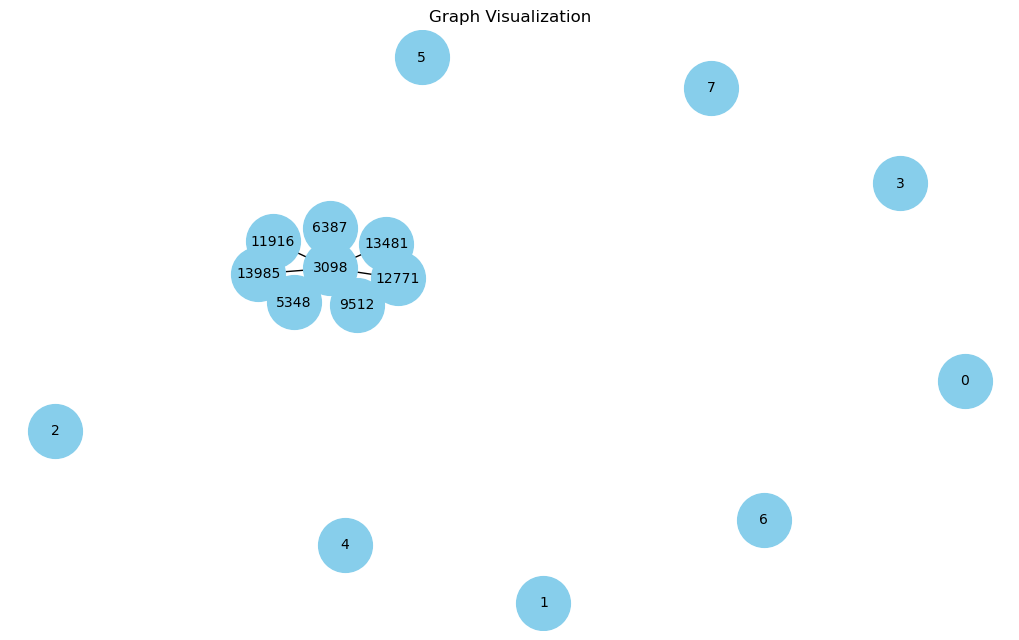

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

# 그래프 데이터를 NetworkX 그래프로 변환
graph = to_networkx(pyg_graphs[0], to_undirected=True)

# NetworkX 그래프 시각화
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(graph)  # 그래프 레이아웃 정의
nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='black', linewidths=1, font_size=10)
plt.title('Graph Visualization')
plt.show()

# 데이터셋 만들기

# 모델 정의

In [ ]:
# NGCF 모델 정의
class NGCF(nn.Module):
    def __init__(self, num_users, num_items, emb_size, layers):
        super(NGCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, emb_size)
        self.item_embedding = nn.Embedding(num_items, emb_size)
        self.GC_layers = nn.ModuleList()
        self.Bi_layers = nn.ModuleList()
        for From, To in zip(layers[:-1], layers[1:]):
            self.GC_layers.append(nn.Linear(From, To))
            self.Bi_layers.append(nn.Linear(From, To))

    def forward(self, user_indices, item_indices, adj_matrix):
        u_emb = self.user_embedding(user_indices)
        i_emb = self.item_embedding(item_indices)
        ego_embeddings = torch.cat([u_emb, i_emb], 0)
        all_embeddings = [ego_embeddings]
        for k in range(len(self.GC_layers)):
            side_embeddings = torch.sparse.mm(adj_matrix, ego_embeddings)
            sum_embeddings = F.leaky_relu(self.GC_layers[k](side_embeddings))
            bi_embeddings = F.leaky_relu(self.Bi_layers[k](ego_embeddings * side_embeddings))
            ego_embeddings = sum_embeddings + bi_embeddings
            all_embeddings += [ego_embeddings]
        all_embeddings = torch.cat(all_embeddings, 1)
        u_g_embeddings, i_g_embeddings = torch.split(all_embeddings, [num_users, num_items], 0)
        return u_g_embeddings, i_g_embeddings